In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
df1 = pd.read_csv(r"D:\desktop\B\数据\标准化后数据\df1.csv")
df2 = pd.read_excel(r"D:\desktop\B\数据\标准化后数据\df2.xlsx")
selected_features = ["CONS", "LDH", "MV", "AST", "CRRT", "U", "L", "HR", "D.Dimer", "CR", "age", "ALT"]
target = 'mort'
X = df1[selected_features]
y = df1[target]
X_train, X_internal_test, y_train, y_internal_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_external_test = df2[selected_features]
y_external_test = df2[target]

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, cross_val_predict
from xgboost import XGBClassifier
from tqdm import tqdm
RANDOM_SEED = 42

# 定义计算置信区间的函数
def bootstrap_metric_ci(y_true, y_pred, metric_func, n_bootstraps=10000, ci=95, random_state=42):
    rng = np.random.RandomState(random_state)
    bootstrapped_scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for _ in range(n_bootstraps):
        indices = resample(np.arange(len(y_true)), replace=True, random_state=rng)
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    lower_bound = np.percentile(bootstrapped_scores, (100-ci)/2)
    upper_bound = np.percentile(bootstrapped_scores, 100-(100-ci)/2)
    return lower_bound, upper_bound

# 定义XGBoost模型参数
params_xgb = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

best_models_xgb = {}
progress_bar = tqdm(total=len(params_xgb) * len(selected_features))
# 逐步添加特征并训练模型
for i in range(1, len(selected_features) + 1):
    current_features = selected_features[:i]
    X_train_current = X_train[current_features]
    X_internal_test_current = X_internal_test[current_features]
    X_external_test_current = X_external_test[current_features]

    model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True, random_state=RANDOM_SEED)
    grid_xgb = GridSearchCV(model_xgb, params_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_xgb.fit(X_train_current, y_train)

    best_model_xgb = grid_xgb.best_estimator_

    # 使用交叉验证在训练集和内部验证集上进行预测
    y_train_pred_cv = cross_val_predict(best_model_xgb, X_train_current, y_train, cv=10, method='predict')
    y_train_proba_cv = cross_val_predict(best_model_xgb, X_train_current, y_train, cv=10, method='predict_proba')[:, 1]
    
    y_internal_pred_cv = cross_val_predict(best_model_xgb, X_internal_test_current, y_internal_test, cv=10, method='predict')
    y_internal_proba_cv = cross_val_predict(best_model_xgb, X_internal_test_current, y_internal_test, cv=10, method='predict_proba')[:, 1]

    # 进行外部测试集预测
    y_external_pred_xgb = best_model_xgb.predict(X_external_test_current)
    y_external_proba_xgb = best_model_xgb.predict_proba(X_external_test_current)[:, 1]
    
    # 计算训练集的各项指标及其置信区间
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred_cv),
        'precision': precision_score(y_train, y_train_pred_cv, average='weighted', zero_division=0),
        'recall': recall_score(y_train, y_train_pred_cv, average='weighted'),
        'f1_score': f1_score(y_train, y_train_pred_cv, average='weighted'),
        'auc': roc_auc_score(y_train, y_train_proba_cv)
    }

    train_ci = {
        'accuracy_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, accuracy_score),
        'precision_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0)),
        'recall_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')),
        'f1_score_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
        'auc_ci': bootstrap_metric_ci(y_train, y_train_proba_cv, roc_auc_score)
    }

    # 计算内部验证集的各项指标及其置信区间
    internal_metrics = {
        'accuracy': accuracy_score(y_internal_test, y_internal_pred_cv),
        'precision': precision_score(y_internal_test, y_internal_pred_cv, average='weighted', zero_division=0),
        'recall': recall_score(y_internal_test, y_internal_pred_cv, average='weighted'),
        'f1_score': f1_score(y_internal_test, y_internal_pred_cv, average='weighted'),
        'auc': roc_auc_score(y_internal_test, y_internal_proba_cv)
    }

    internal_ci = {
        'accuracy_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, accuracy_score),
        'precision_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0)),
        'recall_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')),
        'f1_score_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
        'auc_ci': bootstrap_metric_ci(y_internal_test, y_internal_proba_cv, roc_auc_score)
    }

    # 计算外部验证集的各项指标及其置信区间
    external_metrics = {
        'accuracy': accuracy_score(y_external_test, y_external_pred_xgb),
        'precision': precision_score(y_external_test, y_external_pred_xgb, average='weighted', zero_division=0),
        'recall': recall_score(y_external_test, y_external_pred_xgb, average='weighted'),
        'f1_score': f1_score(y_external_test, y_external_pred_xgb, average='weighted'),
        'auc': roc_auc_score(y_external_test, y_external_proba_xgb)
    }

    external_ci = {
        'accuracy_ci': bootstrap_metric_ci(y_external_test, y_external_pred_xgb, accuracy_score),
        'precision_ci': bootstrap_metric_ci(y_external_test, y_external_pred_xgb, lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0)),
        'recall_ci': bootstrap_metric_ci(y_external_test, y_external_pred_xgb, lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')),
        'f1_score_ci': bootstrap_metric_ci(y_external_test, y_external_pred_xgb, lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
        'auc_ci': bootstrap_metric_ci(y_external_test, y_external_proba_xgb, roc_auc_score)
    }

    best_models_xgb[i] = {
        'features': current_features,
        'train_metrics': train_metrics,
        'train_ci': train_ci,
        'internal_metrics': internal_metrics,
        'internal_ci': internal_ci,
        'external_metrics': external_metrics,
        'external_ci': external_ci,
        'best_params': grid_xgb.best_params_
    }

# 输出每个模型的结果
for i, results in best_models_xgb.items():
    print(f"\nModel with top {i} features: {results['features']}")
    print("Best Parameters:", results['best_params'])
    
    print("Training Set Metrics:")
    for metric, value in results['train_metrics'].items():
        print(f"{metric.capitalize()}: {value:.4f} 置信区间: {results['train_ci'][metric+'_ci'][0]:.4f}-{results['train_ci'][metric+'_ci'][1]:.4f}")

    print("Internal Validation Set Metrics:")
    for metric, value in results['internal_metrics'].items():
        print(f"{metric.capitalize()}: {value:.4f} 置信区间: {results['internal_ci'][metric+'_ci'][0]:-.4f}-{results['internal_ci'][metric+'_ci'][1]:.4f}")
    
    print("External Validation Set Metrics:")
    for metric, value in results['external_metrics'].items():
        print(f"{metric.capitalize()}: {value:.4f} 置信区间: {results['external_ci'][metric+'_ci'][0]:.4f}-{results['external_ci'][metric+'_ci'][1]:.4f}")



  0%|                                                                                           | 0/35 [15:42<?, ?it/s]



Model with top 1 features: ['CONS']
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Training Set Metrics:
Accuracy: 0.7647 置信区间: 0.7059-0.8235
Precision: 0.5848 置信区间: 0.4983-0.6782
Recall: 0.7647 置信区间: 0.7059-0.8235
F1_score: 0.6627 置信区间: 0.5842-0.7438
Auc: 0.7927 置信区间: 0.7056-0.8726
Internal Validation Set Metrics:
Accuracy: 0.7273 置信区间: 0.6364-0.8182
Precision: 0.5289 置信区间: 0.4050-0.6694
Recall: 0.7273 置信区间: 0.6364-0.8182
F1_score: 0.6124 置信区间: 0.4949-0.7364
Auc: 0.7025 置信区间: 0.5702-0.8255
External Validation Set Metrics:
Accuracy: 0.7500 置信区间: 0.6635-0.8269
Precision: 0.5625 置信区间: 0.4402-0.6838
Recall: 0.7500 置信区间: 0.6635-0.8269
F1_score: 0.6429 置信区间: 0.5292-0.7486
Auc: 0.7628 置信区间: 0.6643-0.8610

Model with top 2 features: ['CONS', 'LDH']
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Training Set Metrics:
Accuracy: 0.8431 置信区间: 0.7892-0.892

In [3]:
import pandas as pd
import os

# 设置输出文件夹路径
output_folder = r"D:\desktop\B\结果\表格\内部外部验证结果"
os.makedirs(output_folder, exist_ok=True)  # 确保输出文件夹存在

# 用于存储结果的列表
output_data = []

# 遍历模型结果并将其组织为字典
for i, results in best_models_xgb.items():
    model_name = f"Model with top {i} features"
    for metric in results['train_metrics'].keys():
        output_data.append({
            'Model': model_name,
            'Dataset': 'Training Set',
            'Metric': metric.capitalize(),
            'Value': results['train_metrics'][metric],
            'Confidence Interval': f"{results['train_ci'][metric+'_ci'][0]:.4f}-{results['train_ci'][metric+'_ci'][1]:.4f}"
        })
        output_data.append({
            'Model': model_name,
            'Dataset': 'Internal Validation Set',
            'Metric': metric.capitalize(),
            'Value': results['internal_metrics'][metric],
            'Confidence Interval': f"{results['internal_ci'][metric+'_ci'][0]:.4f}-{results['internal_ci'][metric+'_ci'][1]:.4f}"
        })
        output_data.append({
            'Model': model_name,
            'Dataset': 'External Validation Set',
            'Metric': metric.capitalize(),
            'Value': results['external_metrics'][metric],
            'Confidence Interval': f"{results['external_ci'][metric+'_ci'][0]:.4f}-{results['external_ci'][metric+'_ci'][1]:.4f}"
        })

# 将列表转换为 DataFrame
output_df = pd.DataFrame(output_data)

# 设置文件名
output_file = os.path.join(output_folder, "XGB_Results.xlsx")

# 将 DataFrame 保存为 Excel 文件
output_df.to_excel(output_file, index=False)

print(f"结果已保存至：{output_file}")


结果已保存至：D:\desktop\B\结果\表格\内部外部验证结果\XGB_Results.xlsx


最佳7个特征单独训练

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.utils import resample
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
df1 = pd.read_csv(r"D:\desktop\B\数据\标准化后数据\df1.csv")
df2 = pd.read_excel(r"D:\desktop\B\数据\标准化后数据\df2.xlsx")
selected_features = ["CONS", "LDH", "MV", "AST", "CRRT", "U", "L"]
target = 'mort'
X = df1[selected_features]
y = df1[target]
X_train, X_internal_test, y_train, y_internal_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_external_test = df2[selected_features]
y_external_test = df2[target]
RANDOM_SEED = 42

# 定义计算置信区间的函数
def bootstrap_metric_ci(y_true, y_pred, metric_func, n_bootstraps=10000, ci=95, random_state=42):
    rng = np.random.RandomState(random_state)
    bootstrapped_scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for _ in range(n_bootstraps):
        indices = resample(np.arange(len(y_true)), replace=True, random_state=rng)
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    lower_bound = np.percentile(bootstrapped_scores, (100-ci)/2)
    upper_bound = np.percentile(bootstrapped_scores, 100-(100-ci)/2)
    return lower_bound, upper_bound

# 使用选定的最佳特征
selected_features = ['CONS', 'LDH', 'MV', 'AST', 'CRRT', 'U', 'L']

# 使用最佳参数
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 150,
    'subsample': 0.8
}

# 创建XGB模型实例
model_xgb = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', enable_categorical=True, random_state=RANDOM_SEED)

# 训练模型
model_xgb.fit(X_train[selected_features], y_train)

# 进行交叉验证预测（训练集和内部验证集）
y_train_pred_cv = cross_val_predict(model_xgb, X_train[selected_features], y_train, cv=10, method='predict')
y_train_proba_cv = cross_val_predict(model_xgb, X_train[selected_features], y_train, cv=10, method='predict_proba')[:, 1]

y_internal_pred_cv = cross_val_predict(model_xgb, X_internal_test[selected_features], y_internal_test, cv=10, method='predict')
y_internal_proba_cv = cross_val_predict(model_xgb, X_internal_test[selected_features], y_internal_test, cv=10, method='predict_proba')[:, 1]

# 对外部验证集进行单次预测
y_external_pred_xgb = model_xgb.predict(X_external_test[selected_features])
y_external_proba_xgb = model_xgb.predict_proba(X_external_test[selected_features])[:, 1]

# 计算训练集的各项指标及其置信区间
train_metrics = {
    'accuracy': accuracy_score(y_train, y_train_pred_cv),
    'precision': precision_score(y_train, y_train_pred_cv, average='weighted', zero_division=0),
    'recall': recall_score(y_train, y_train_pred_cv, average='weighted'),
    'f1_score': f1_score(y_train, y_train_pred_cv, average='weighted'),
    'auc': roc_auc_score(y_train, y_train_proba_cv)
}

train_ci = {
    'accuracy_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, accuracy_score),
    'precision_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0)),
    'recall_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')),
    'f1_score_ci': bootstrap_metric_ci(y_train, y_train_pred_cv, lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
    'auc_ci': bootstrap_metric_ci(y_train, y_train_proba_cv, roc_auc_score)
}

# 计算内部验证集的各项指标及其置信区间
internal_metrics = {
    'accuracy': accuracy_score(y_internal_test, y_internal_pred_cv),
    'precision': precision_score(y_internal_test, y_internal_pred_cv, average='weighted', zero_division=0),
    'recall': recall_score(y_internal_test, y_internal_pred_cv, average='weighted'),
    'f1_score': f1_score(y_internal_test, y_internal_pred_cv, average='weighted'),
    'auc': roc_auc_score(y_internal_test, y_internal_proba_cv)
}

internal_ci = {
    'accuracy_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, accuracy_score),
    'precision_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0)),
    'recall_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')),
    'f1_score_ci': bootstrap_metric_ci(y_internal_test, y_internal_pred_cv, lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
    'auc_ci': bootstrap_metric_ci(y_internal_test, y_internal_proba_cv, roc_auc_score)
}

# 计算外部验证集的各项指标及其置信区间
external_metrics = {
    'accuracy': accuracy_score(y_external_test, y_external_pred_xgb),
    'precision': precision_score(y_external_test, y_external_pred_xgb, average='weighted', zero_division=0),
    'recall': recall_score(y_external_test, y_external_pred_xgb, average='weighted'),
    'f1_score': f1_score(y_external_test, y_external_pred_xgb, average='weighted'),
    'auc': roc_auc_score(y_external_test, y_external_proba_xgb)
}

external_ci = {
    'accuracy_ci': bootstrap_metric_ci(y_external_test, y_external_pred_xgb, accuracy_score),
    'precision_ci': bootstrap_metric_ci(y_external_test, y_external_pred_xgb, lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0)),
    'recall_ci': bootstrap_metric_ci(y_external_test, y_external_pred_xgb, lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')),
    'f1_score_ci': bootstrap_metric_ci(y_external_test, y_external_pred_xgb, lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
    'auc_ci': bootstrap_metric_ci(y_external_test, y_external_proba_xgb, roc_auc_score)
}

# 输出结果
print(f"Model with top 7 features: {selected_features}")
print("Best Parameters:", params)

print("Training Set Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f} 置信区间: {train_ci[metric+'_ci'][0]:.4f}-{train_ci[metric+'_ci'][1]:.4f}")

print("Internal Validation Set Metrics:")
for metric, value in internal_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f} 置信区间: {internal_ci[metric+'_ci'][0]:.4f}-{internal_ci[metric+'_ci'][1]:.4f}")
    
print("External Validation Set Metrics:")
for metric, value in external_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f} 置信区间: {external_ci[metric+'_ci'][0]:.4f}-{external_ci[metric+'_ci'][1]:.4f}")


Model with top 7 features: ['CONS', 'LDH', 'MV', 'AST', 'CRRT', 'U', 'L']
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Training Set Metrics:
Accuracy: 0.8529 置信区间: 0.8039-0.9020
Precision: 0.8456 置信区间: 0.7913-0.8982
Recall: 0.8529 置信区间: 0.8039-0.9020
F1_score: 0.8452 置信区间: 0.7891-0.8964
Auc: 0.9129 置信区间: 0.8634-0.9533
Internal Validation Set Metrics:
Accuracy: 0.8409 置信区间: 0.7614-0.9091
Precision: 0.8378 置信区间: 0.7552-0.9179
Recall: 0.8409 置信区间: 0.7614-0.9091
F1_score: 0.8297 置信区间: 0.7381-0.9075
Auc: 0.9108 置信区间: 0.8415-0.9667
External Validation Set Metrics:
Accuracy: 0.8942 置信区间: 0.8365-0.9519
Precision: 0.9073 置信区间: 0.8655-0.9546
Recall: 0.8942 置信区间: 0.8365-0.9519
F1_score: 0.8835 置信区间: 0.8071-0.9490
Auc: 0.8910 置信区间: 0.7855-0.9765


最佳截断值（最大化Youden's Index）

In [2]:
from sklearn.metrics import roc_curve

# 以内部验证集为例计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_internal_test, y_internal_proba_cv)

# 计算特异性
specificity = 1 - fpr

# 计算Youden's Index
youden_index = tpr + specificity - 1

# 找到最大Youden's Index的索引
max_index = np.argmax(youden_index)
optimal_threshold = thresholds[max_index]

print(f"Optimal threshold by Youden's Index: {optimal_threshold}")
print(f"Maximum Youden's Index: {youden_index[max_index]}")

# 输出对应的灵敏度和特异性
print(f"Sensitivity at optimal threshold: {tpr[max_index]}")
print(f"Specificity at optimal threshold: {specificity[max_index]}")


Optimal threshold by Youden's Index: 0.22632412612438202
Maximum Youden's Index: 0.734375
Sensitivity at optimal threshold: 0.875
Specificity at optimal threshold: 0.859375


In [3]:
y_pred_optimal = (y_internal_proba_cv >= optimal_threshold).astype(int)
print("Adjusted Metrics with Optimal Threshold:")
print("Accuracy:", accuracy_score(y_internal_test, y_pred_optimal))
print("Precision:", precision_score(y_internal_test, y_pred_optimal, average='weighted', zero_division=0))
print("Recall:", recall_score(y_internal_test, y_pred_optimal, average='weighted'))
print("F1 Score:", f1_score(y_internal_test, y_pred_optimal, average='weighted'))


Adjusted Metrics with Optimal Threshold:
Accuracy: 0.8636363636363636
Precision: 0.880564263322884
Recall: 0.8636363636363636
F1 Score: 0.8678589170392449


In [13]:
import pandas as pd

# 获取训练集的真实标签和预测概率
y_train_true = y_train.values
train_data = pd.DataFrame({
    'True_Label': y_train_true,
    'Predicted_Probability': y_train_proba_cv
})
train_data.to_csv(r'D:\desktop\B\结果\表格\XGB真实标签和预测概率\train_labels_and_probabilities.csv', index=False)

# 获取内部验证集的真实标签和预测概率
y_internal_true = y_internal_test.values
internal_data = pd.DataFrame({
    'True_Label': y_internal_true,
    'Predicted_Probability': y_internal_proba_cv
})
internal_data.to_csv(r'D:\desktop\B\结果\表格\XGB真实标签和预测概率\internal_validation_labels_and_probabilities.csv', index=False)

# 获取外部验证集的真实标签和预测概率
y_external_true = y_external_test.values
external_data = pd.DataFrame({
    'True_Label': y_external_true,
    'Predicted_Probability': y_external_proba_xgb
})
external_data.to_csv(r'D:\desktop\B\结果\表格\XGB真实标签和预测概率\external_validation_labels_and_probabilities.csv', index=False)

print("训练集、内部验证集和外部验证集的标签和预测概率已保存到指定文件夹。")


训练集、内部验证集和外部验证集的标签和预测概率已保存到指定文件夹。


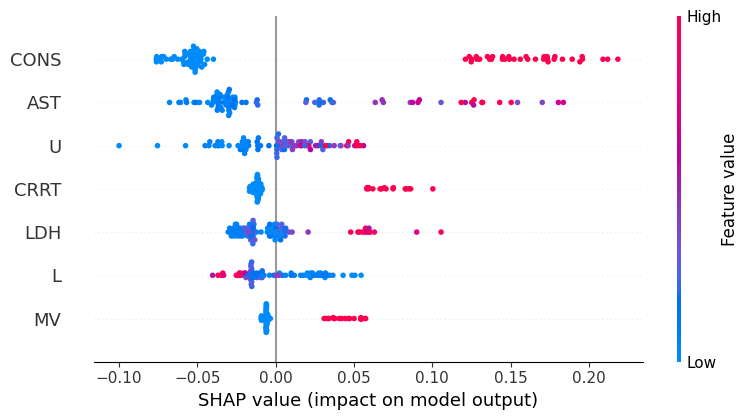

In [2]:
import shap  # 确保已经导入SHAP库

# 创建SHAP解释器对象
explainer = shap.Explainer(model_xgb.predict_proba, X_train[selected_features])

# 计算SHAP值
shap_values = explainer(X_internal_test[selected_features])

# 确保使用正类的SHAP值
shap_values_positive_class = shap_values[..., 1]  # 使用适当的索引以获取正类的SHAP值

# 绘制SHAP总结图，针对正类
shap.summary_plot(shap_values_positive_class.values, 
                  X_internal_test[selected_features], 
                  feature_names=selected_features)


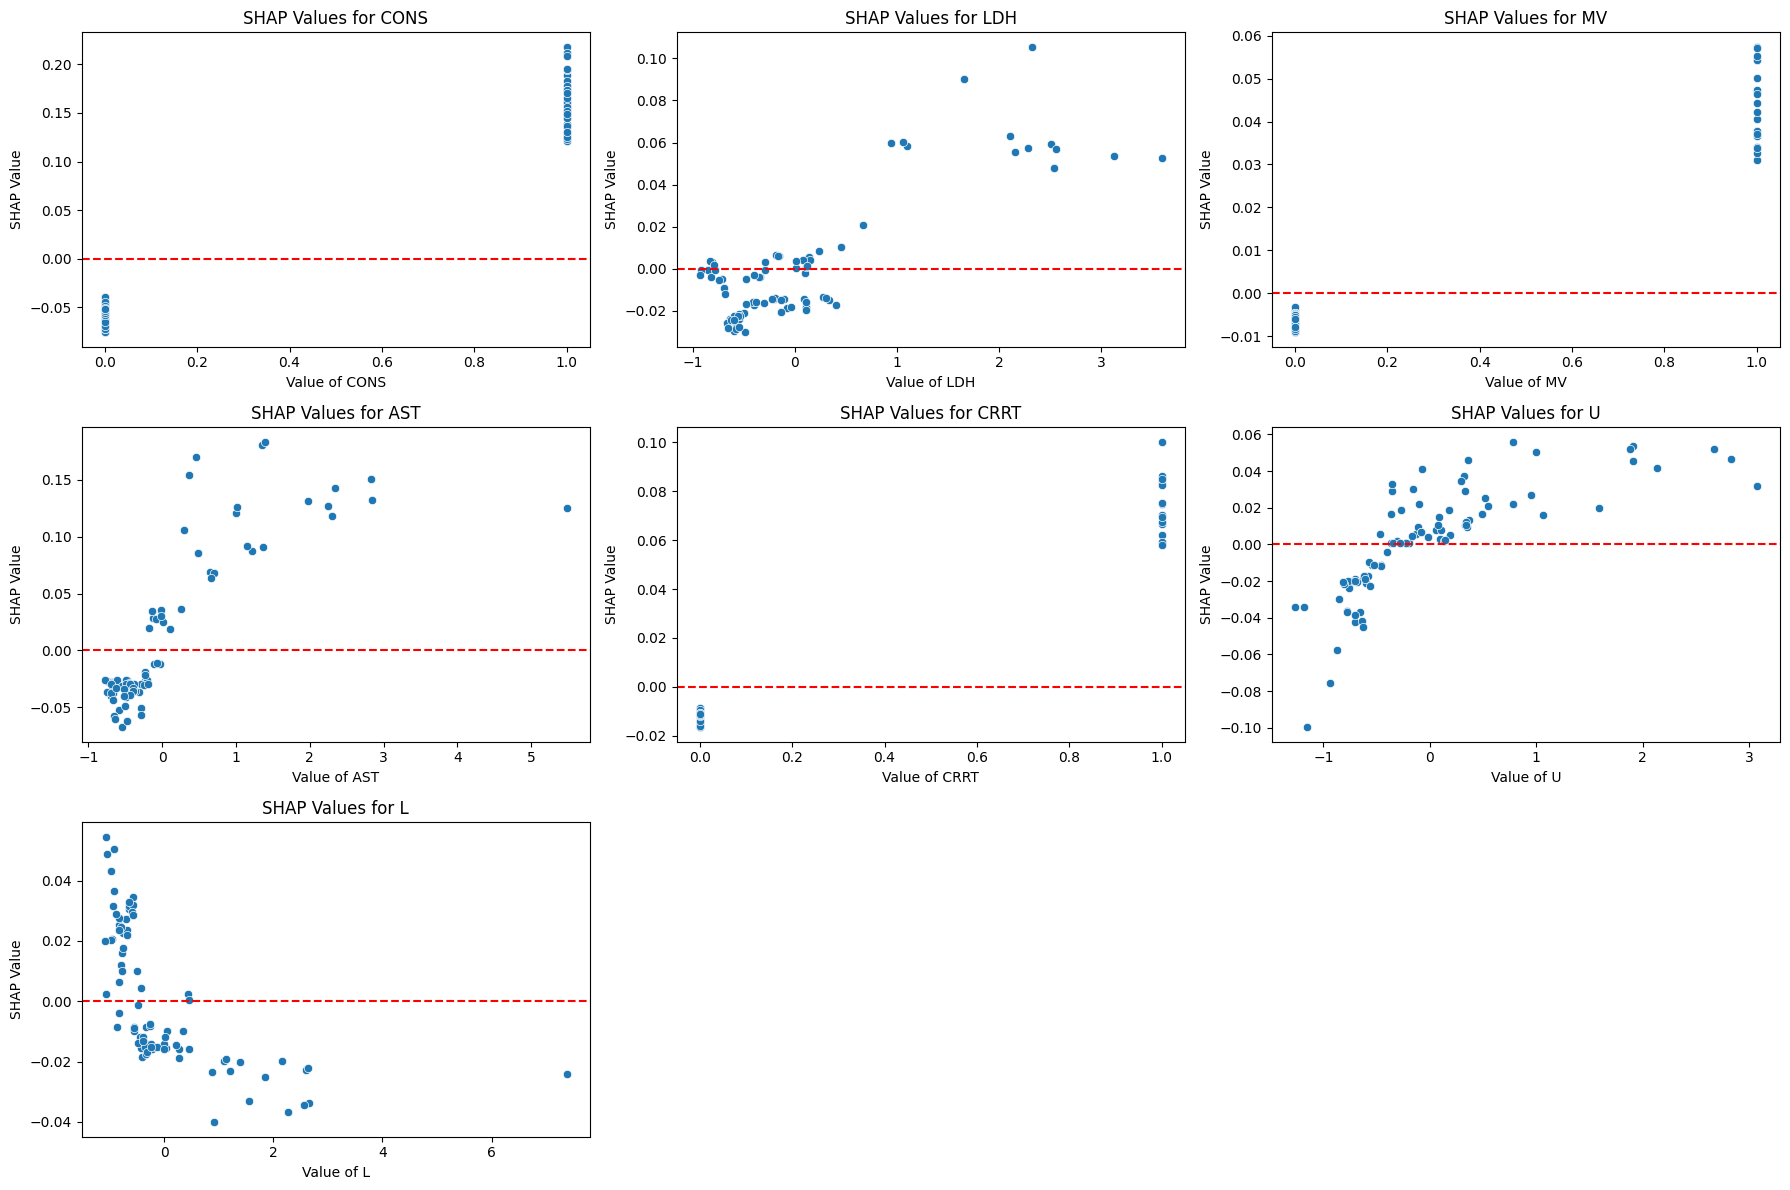

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置图表的总体大小
plt.figure(figsize=(18, 12))

# 遍历所有特征，为每个特征绘制一个散点图
for i, feature in enumerate(selected_features):
    ax = plt.subplot(3, 3, i + 1)
    feature_values = X_internal_test[feature]  # 从测试数据集中提取特征值
    shap_values_feature = shap_values_positive_class.values[:, i]  # 提取特定特征的SHAP值

    # 绘制散点图
    sns.scatterplot(x=feature_values, y=shap_values_feature, ax=ax)
    ax.set_title(f'SHAP Values for {feature}')
    ax.set_xlabel(f'Value of {feature}')
    ax.set_ylabel('SHAP Value')
    ax.axhline(0, color='red', linestyle='--')  # 添加y=0的参考线

plt.tight_layout()  # 调整子图布局
plt.show()  # 显示图表


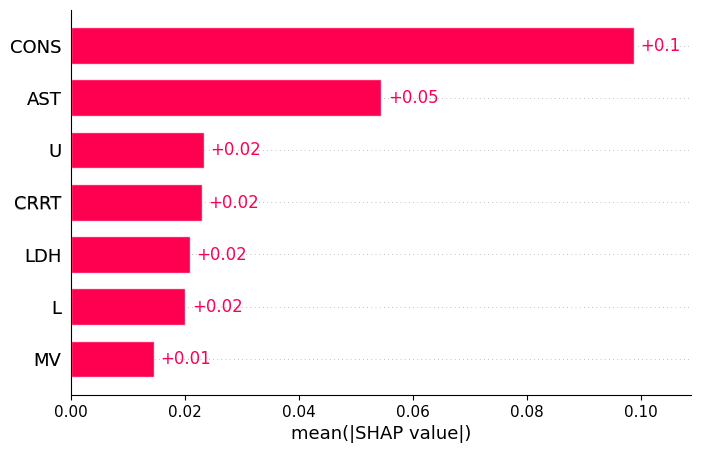

In [8]:
# 如果需要使用 SHAP 条形图
shap.plots.bar(shap_values_positive_class)

SHAP force plot for sample 1:


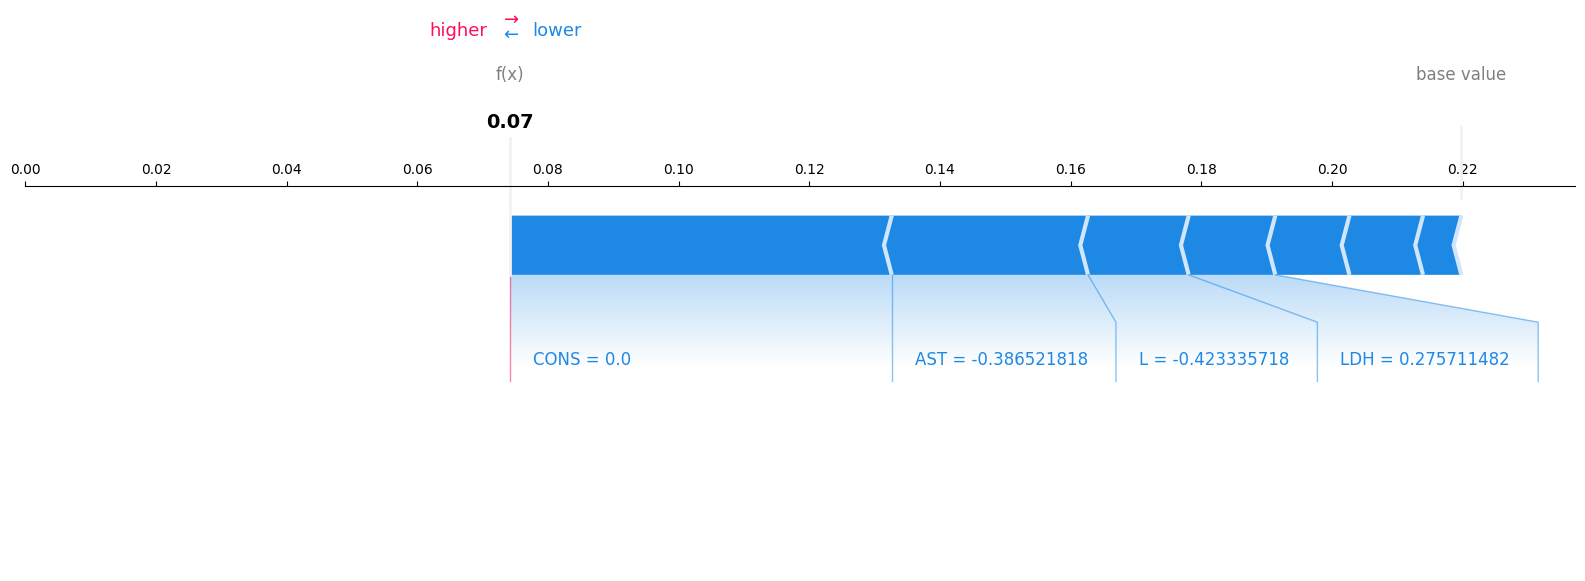

SHAP force plot for sample 2:


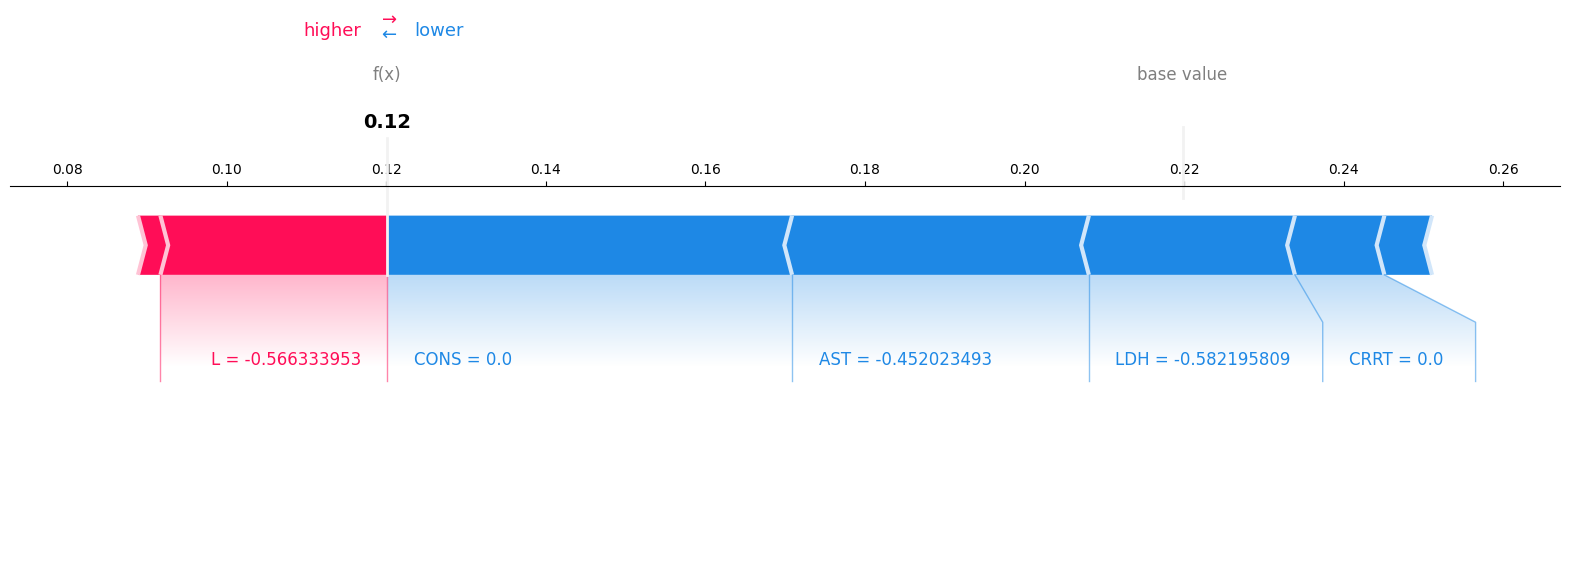

SHAP force plot for sample 3:


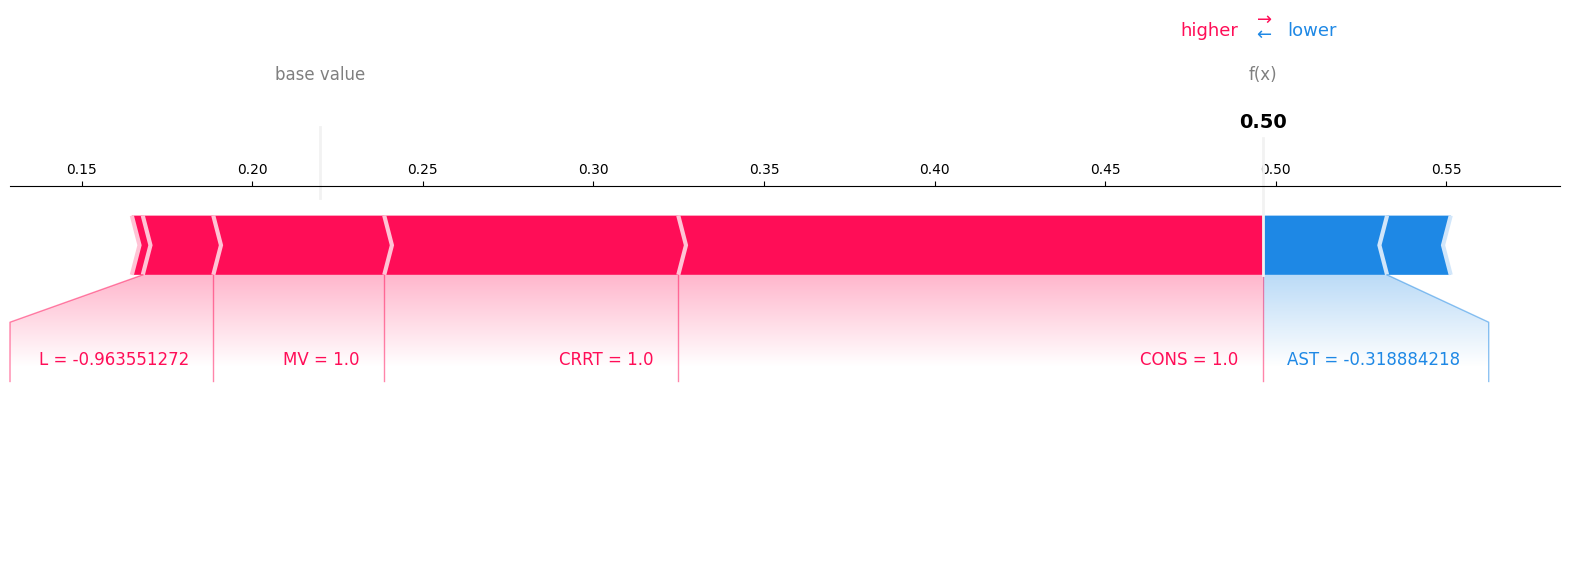

SHAP force plot for sample 4:


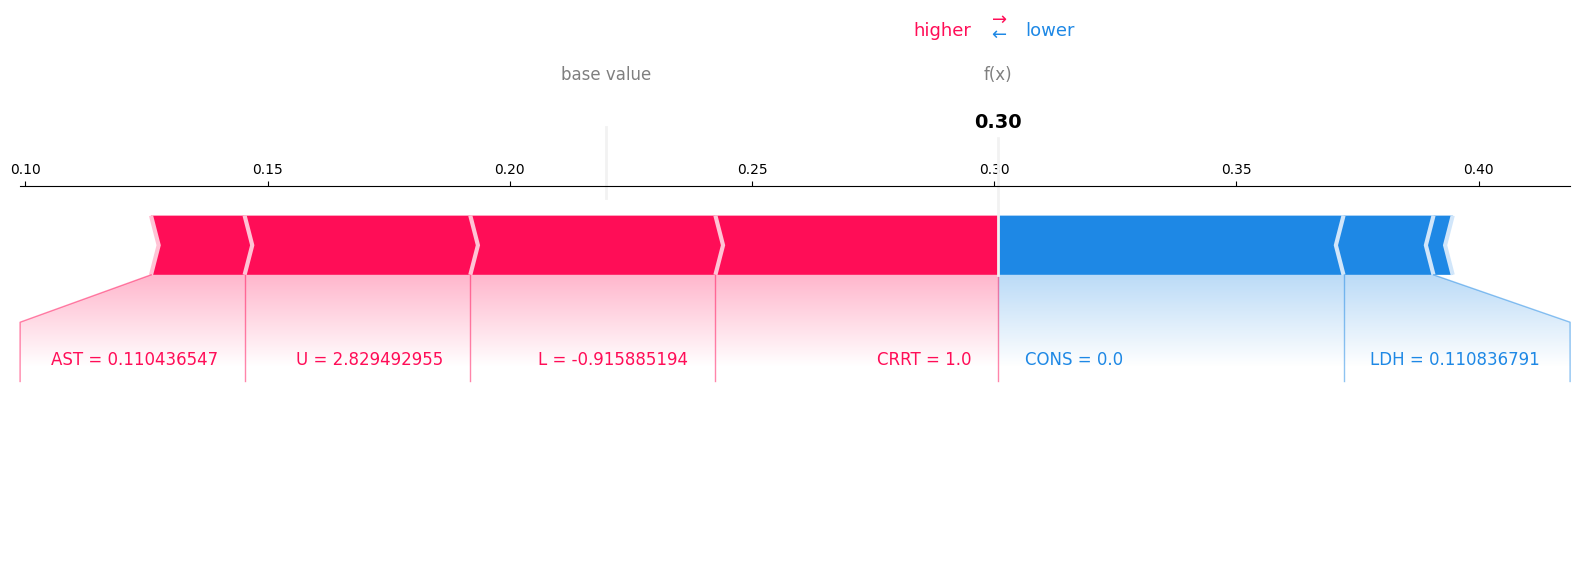

SHAP force plot for sample 5:


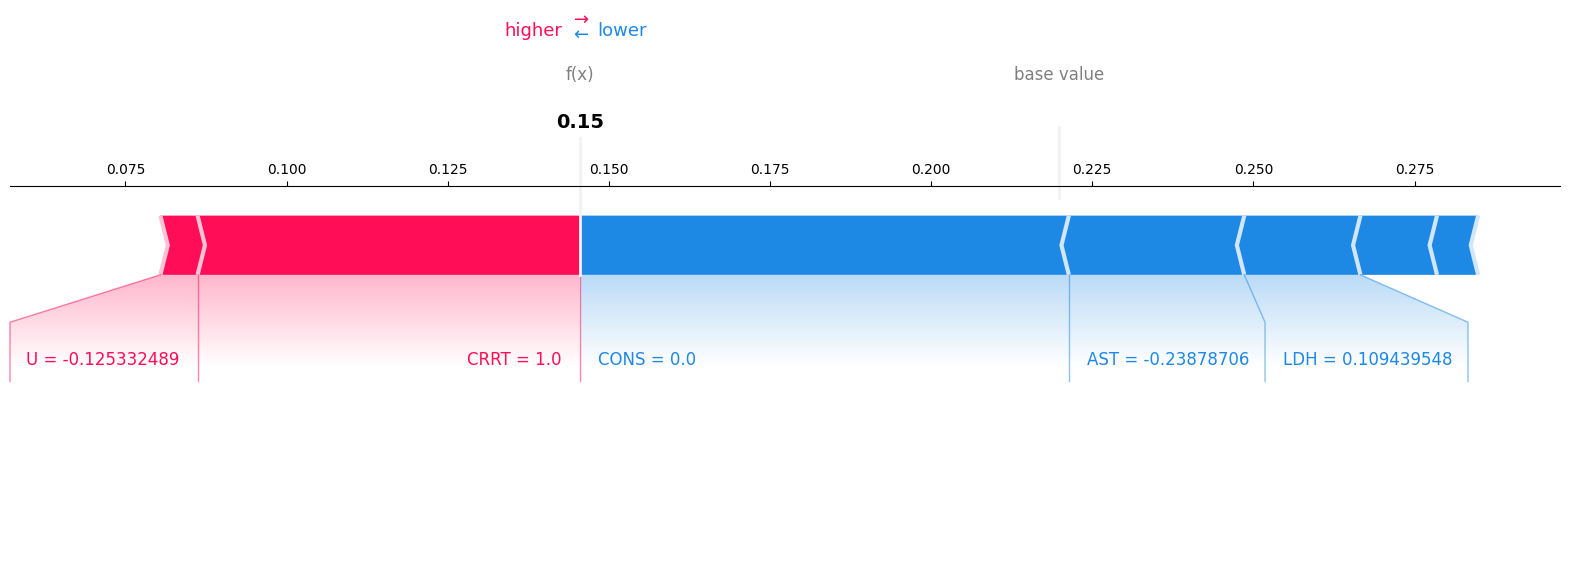

SHAP force plot for sample 6:


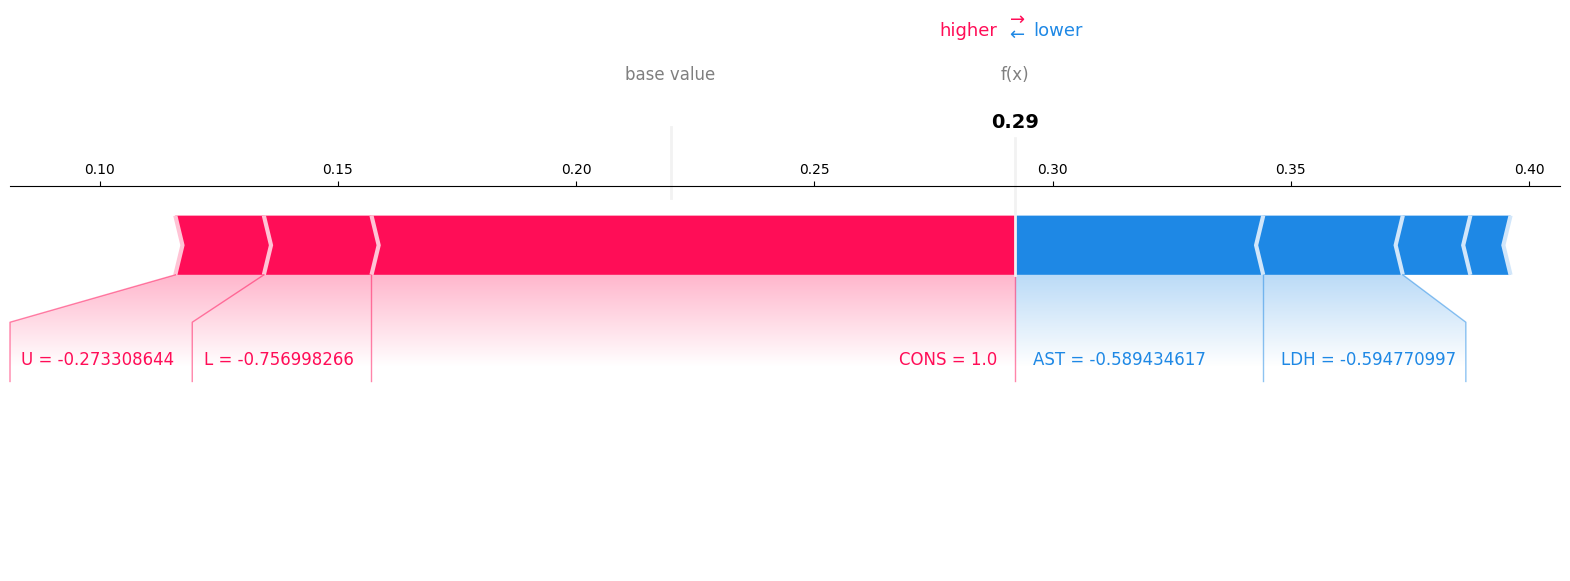

SHAP force plot for sample 7:


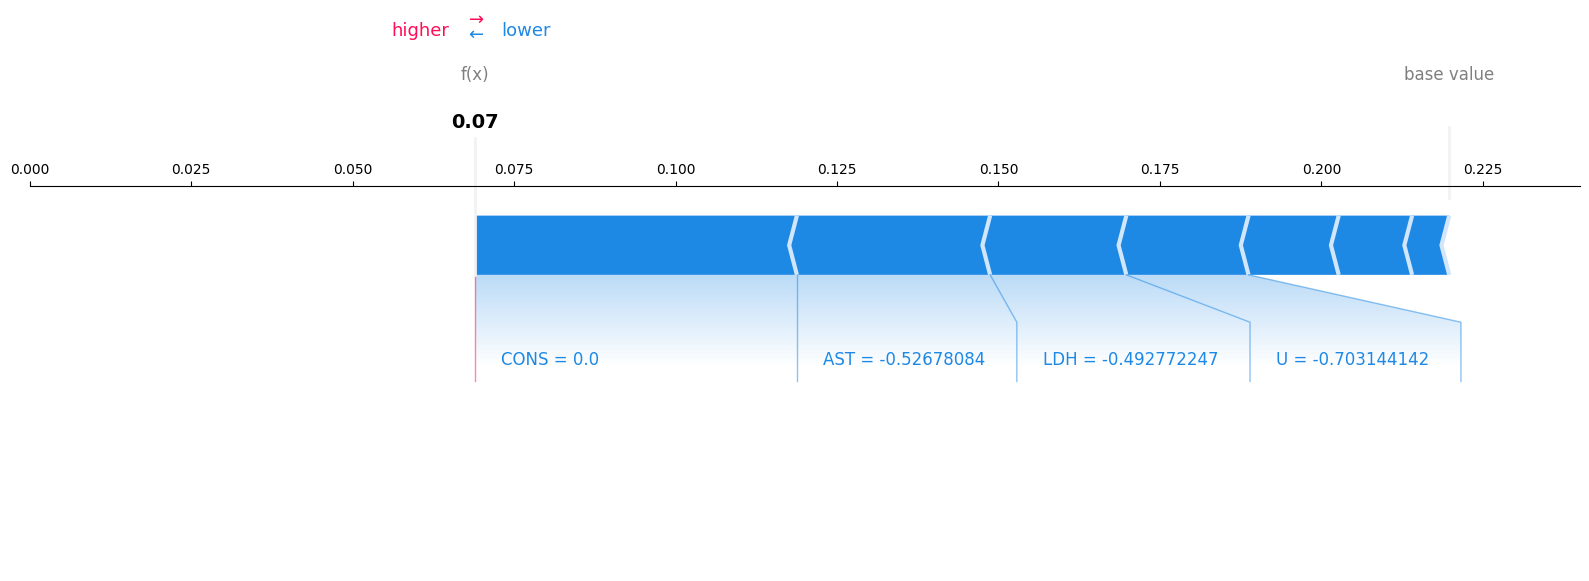

SHAP force plot for sample 8:


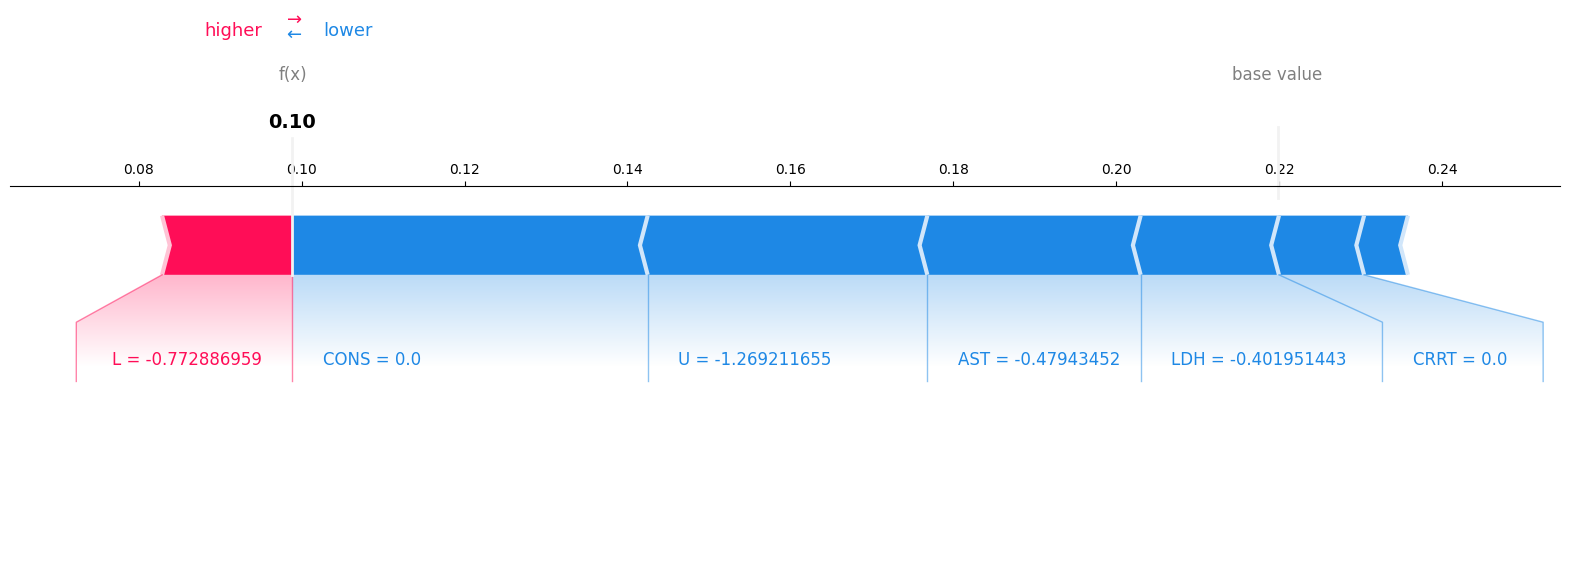

SHAP force plot for sample 9:


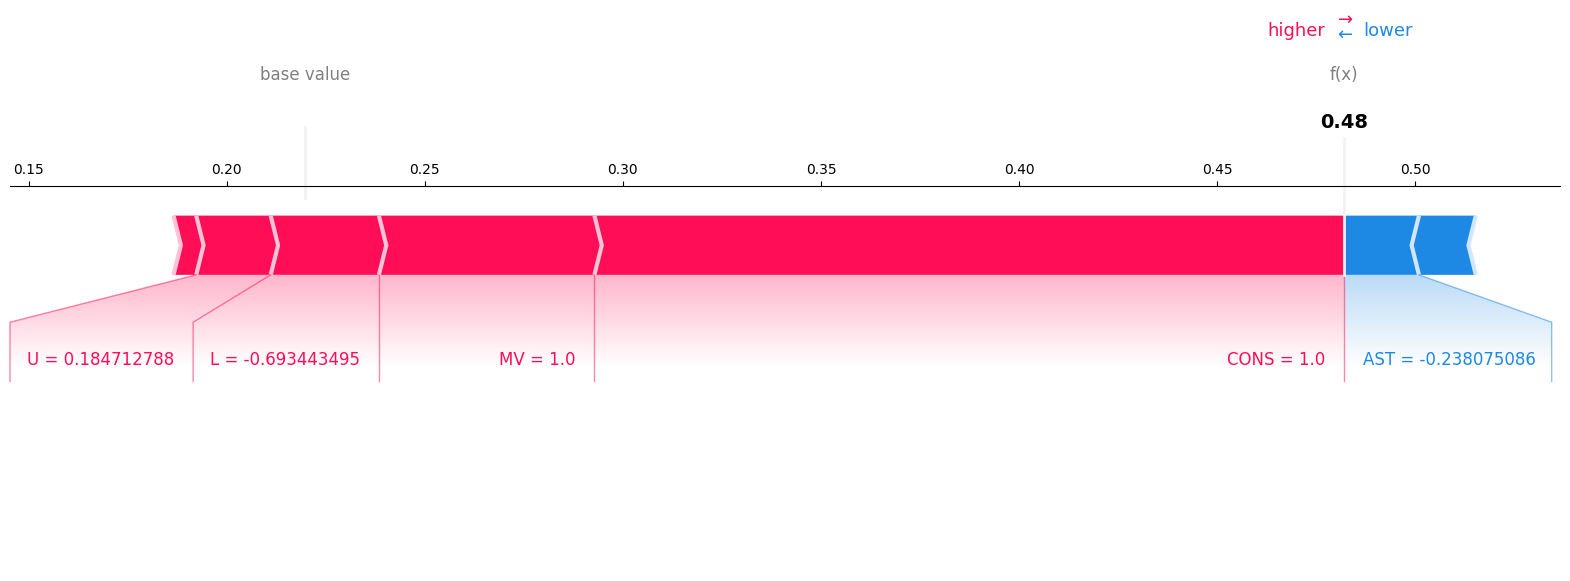

SHAP force plot for sample 10:


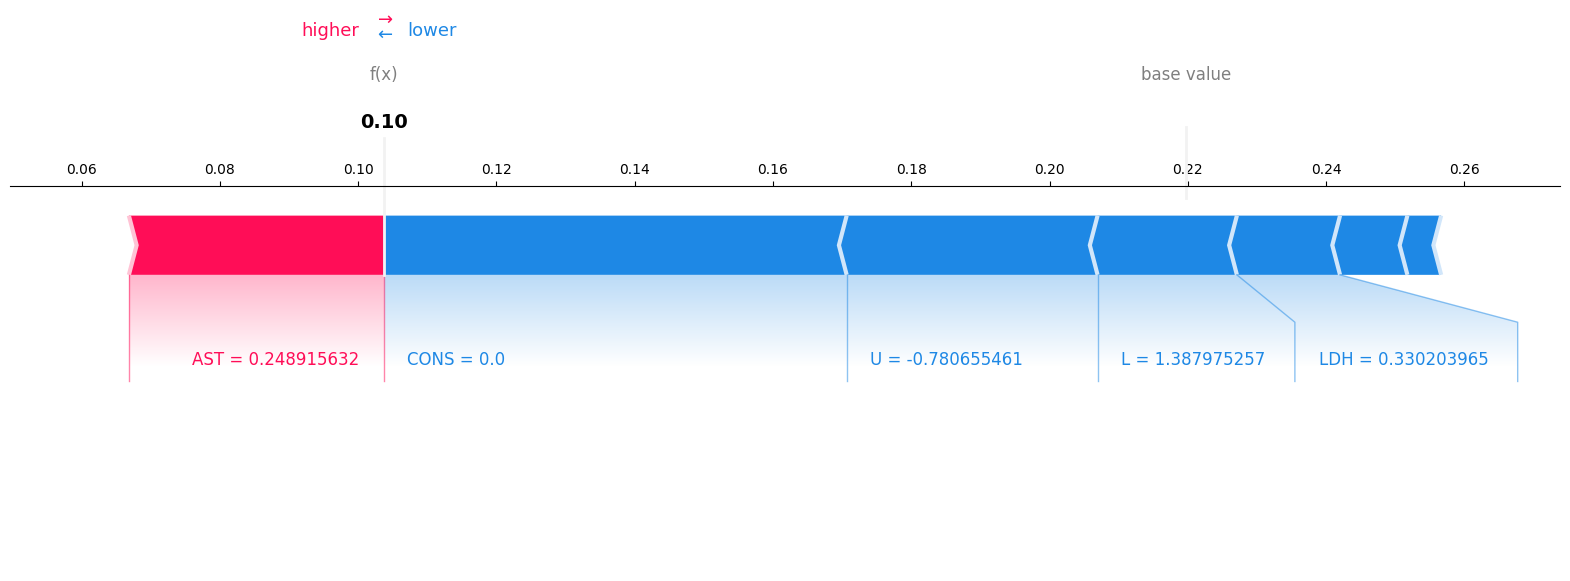

SHAP force plot for sample 11:


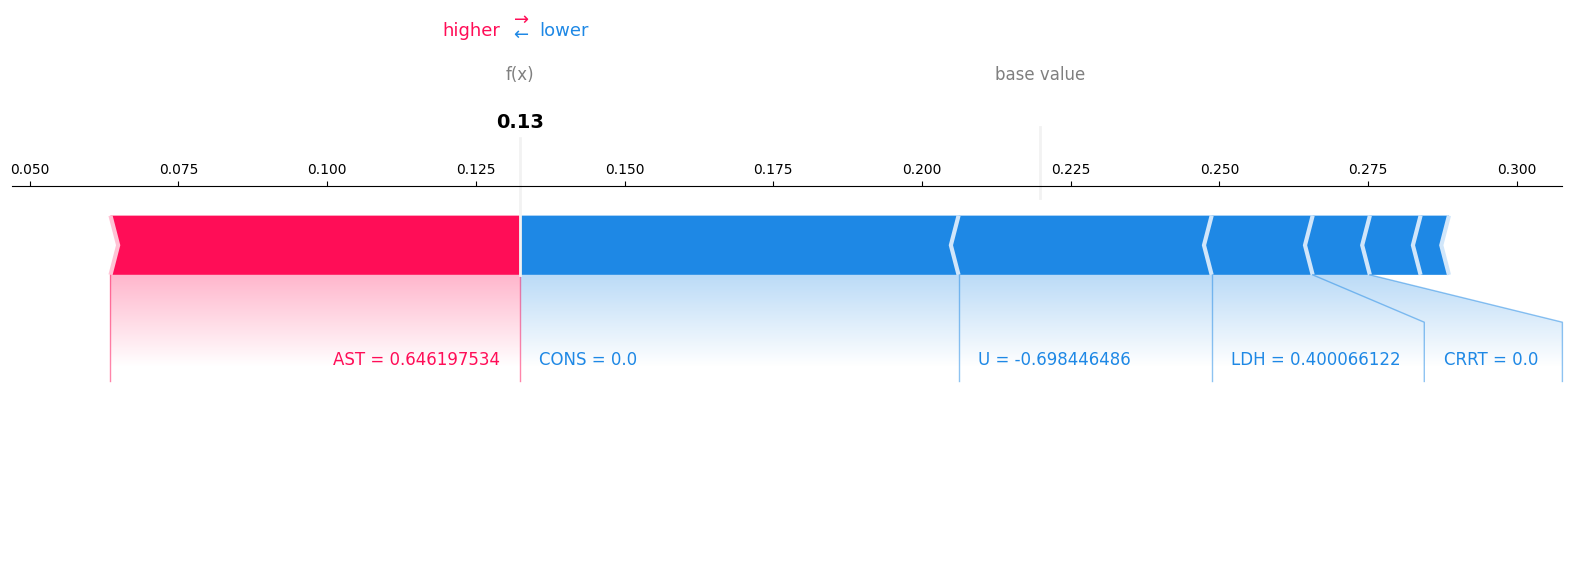

SHAP force plot for sample 12:


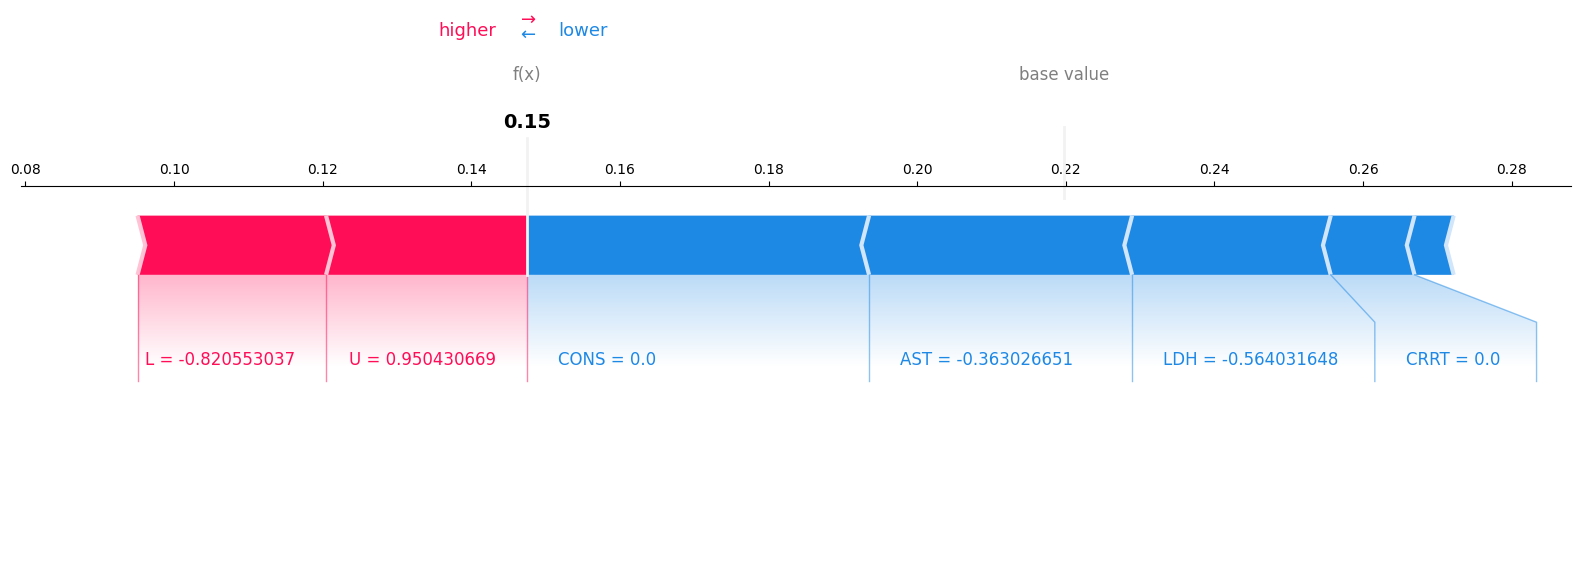

SHAP force plot for sample 13:


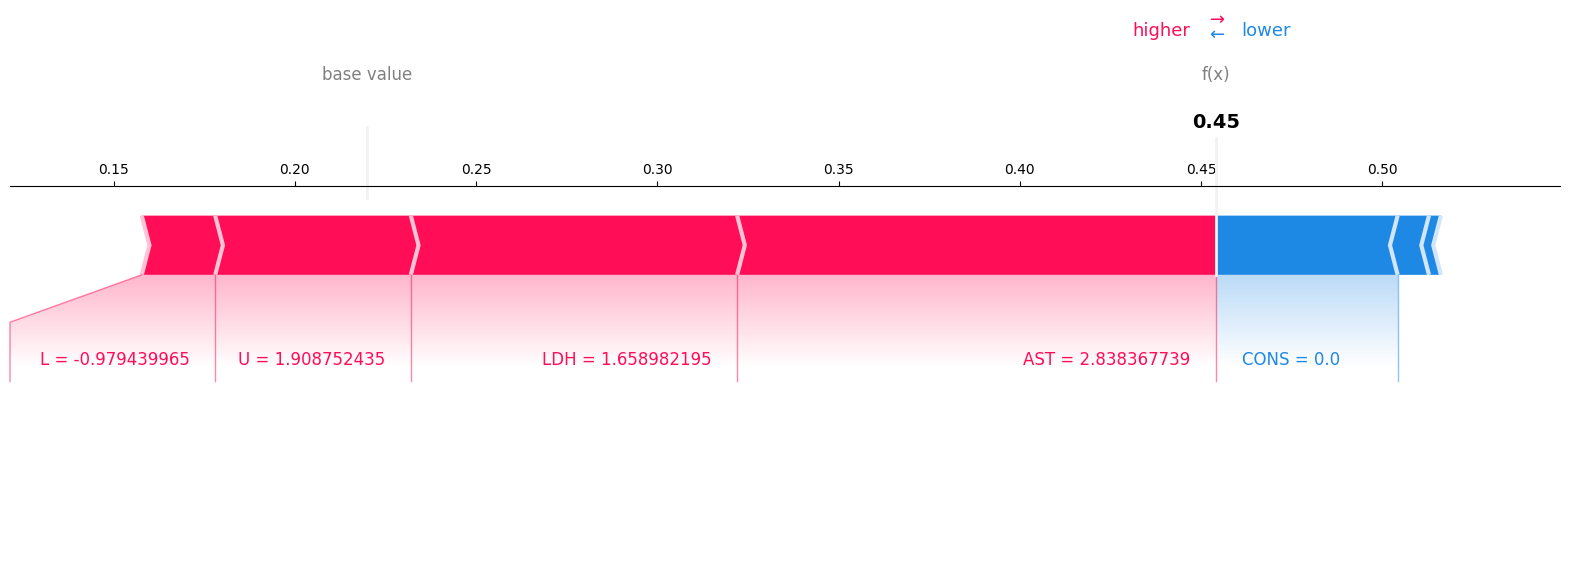

SHAP force plot for sample 14:


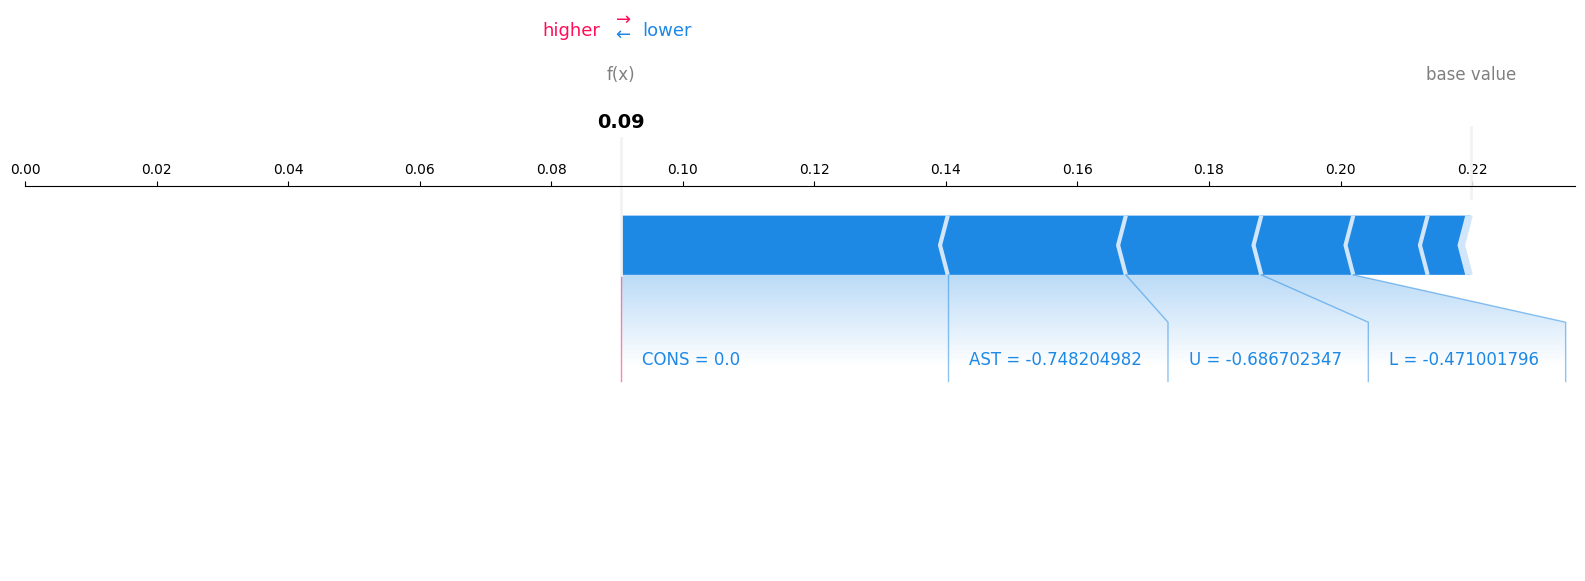

SHAP force plot for sample 15:


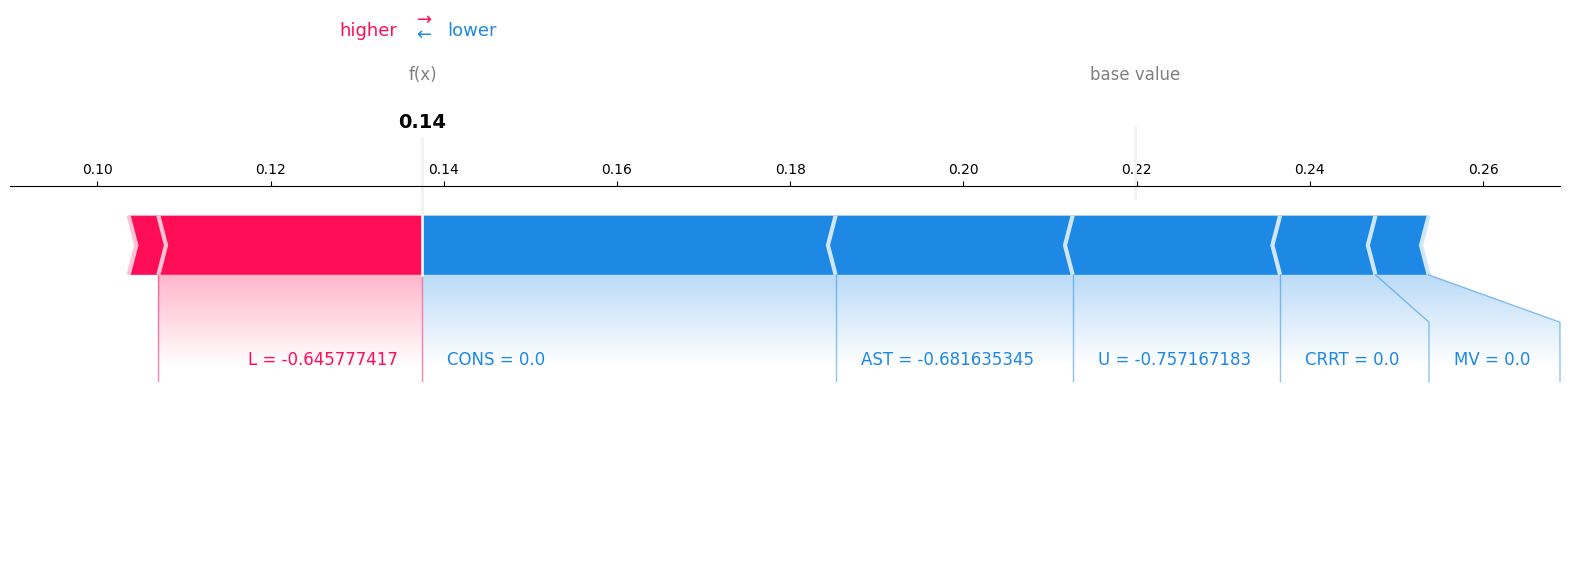

SHAP force plot for sample 16:


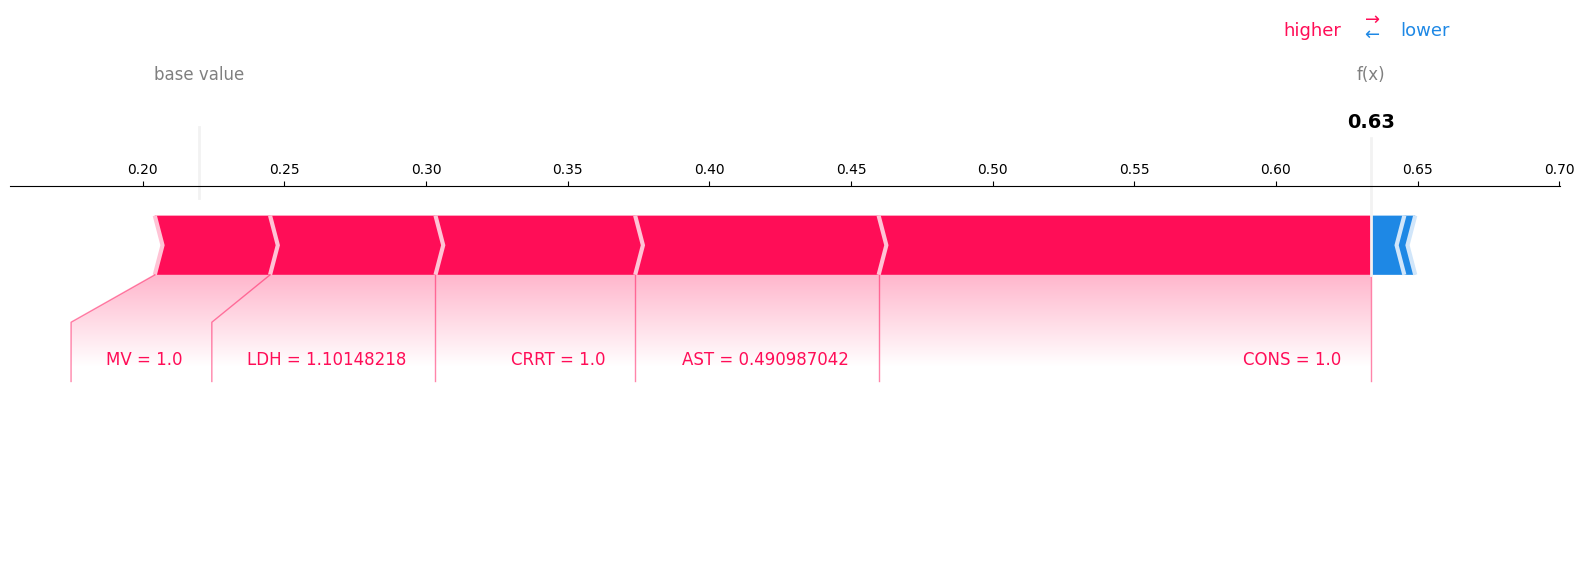

SHAP force plot for sample 17:


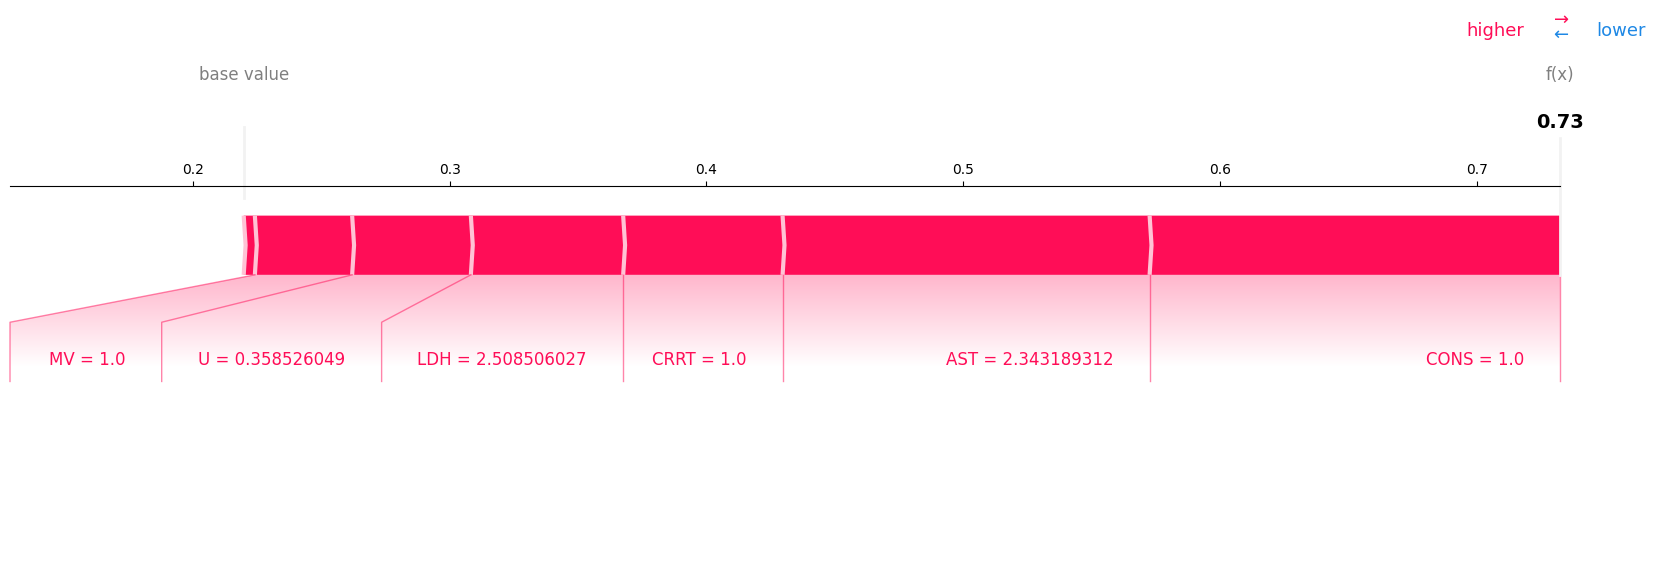

SHAP force plot for sample 18:


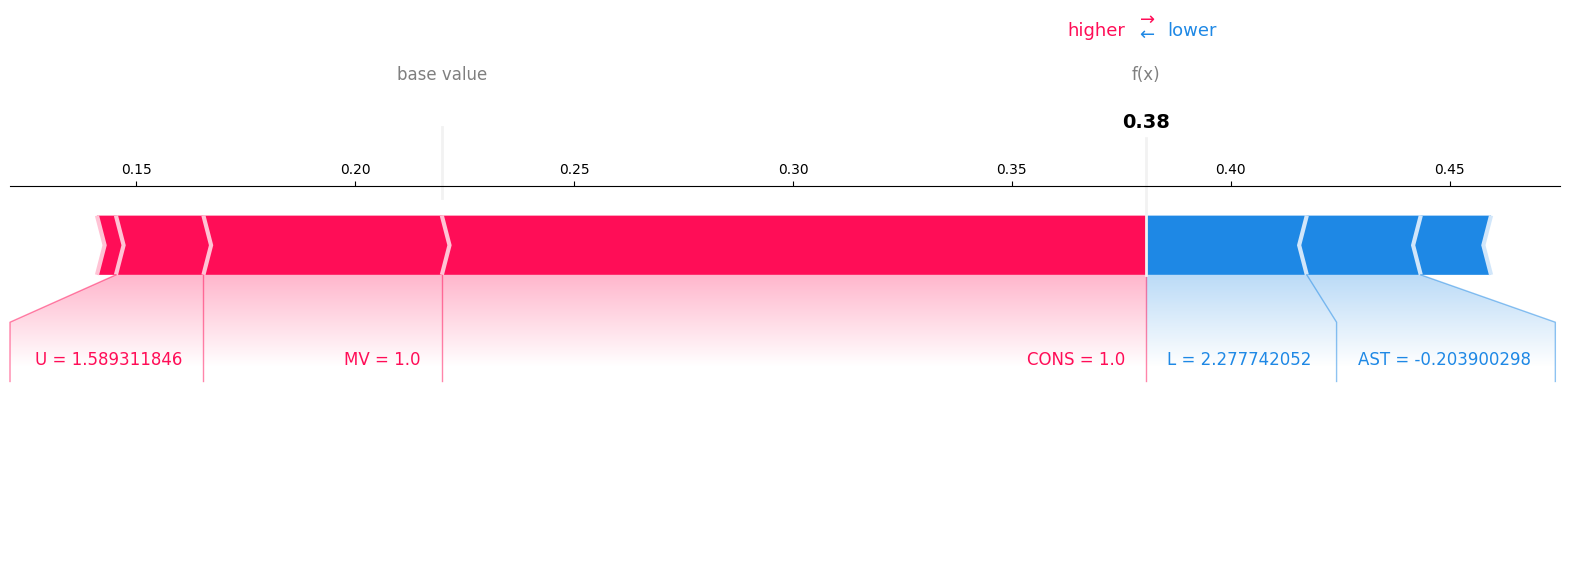

SHAP force plot for sample 19:


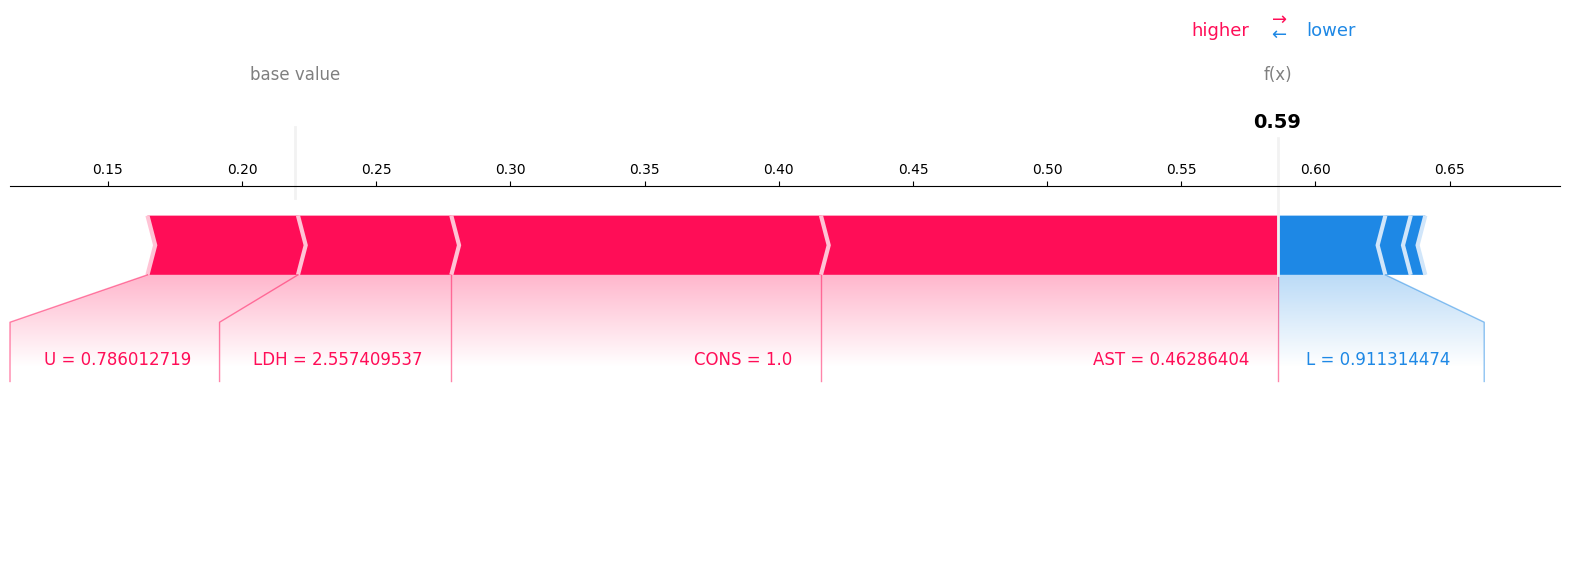

SHAP force plot for sample 20:


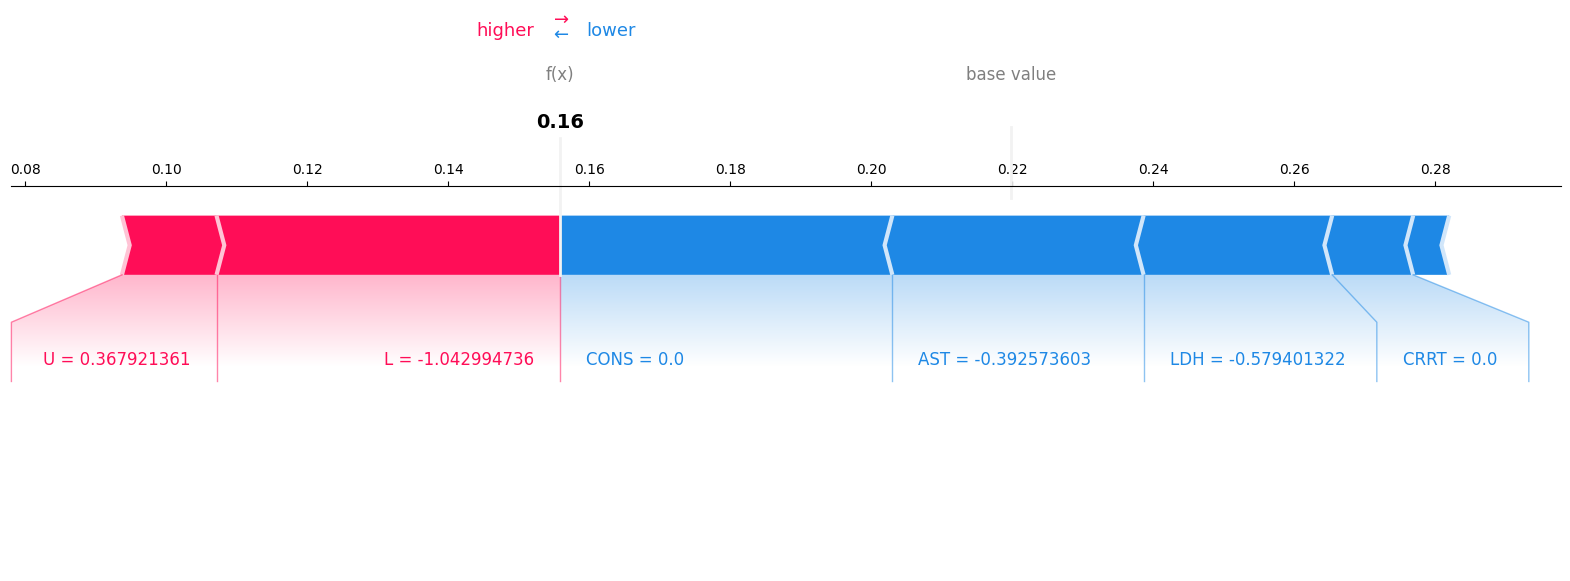

In [9]:
# 导入必要的库，如果还没有导入
import shap

# 初始化SHAP的JavaScript库，主要用于Jupyter Notebook中的交互显示
shap.initjs()

# 循环前五个样本，生成和显示力图
for i in range(20):
    print(f"SHAP force plot for sample {i+1}:")
    shap.plots.force(
        base_value=shap_values[i].base_values[1],  # 第i个样本的基线值，针对正类
        shap_values=shap_values[i].values[:, 1],   # 第i个样本所有特征的SHAP值，针对正类
        features=X_internal_test[selected_features].iloc[i],  # 第i个样本的特征值
        feature_names=selected_features,  # 特征的名称
        matplotlib=True,  # 使用matplotlib渲染图像
        figsize=(20, 5)   # 图像尺寸
    )


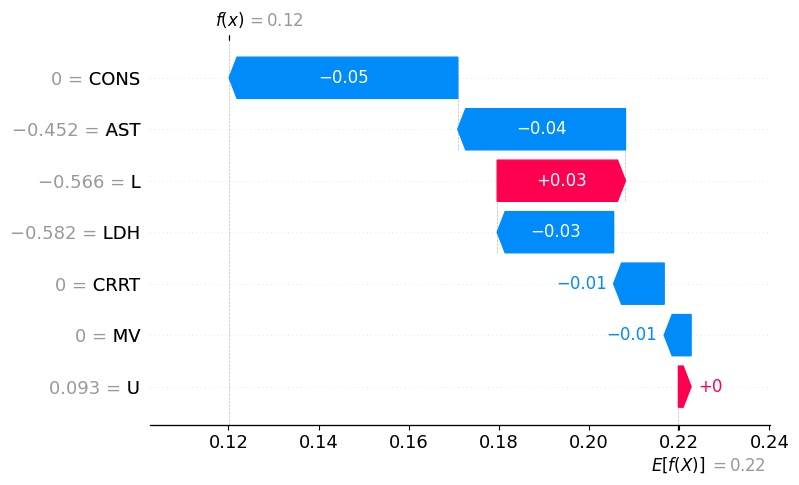

In [3]:
import matplotlib.pyplot as plt
import shap

# 假设已经有了 shap_values、model_xgb、X_train 和 selected_features

# 选择一个样本
sample_index = 1  # 选择特定样本的索引

# 创建针对单个样本和正类的Explanation对象
shap_values_single = shap.Explanation(
    values=shap_values.values[sample_index, :, 1],  # 提取正类的SHAP值
    base_values=shap_values.base_values[sample_index, 1],  # 提取正类的基础值
    data=shap_values.data[sample_index, :],  # 提取样本的特征数据
    feature_names=selected_features  # 特征名称
)

# 绘制瀑布图
shap.plots.waterfall(shap_values_single, max_display=10)  # 控制显示的特征数量

plt.show()


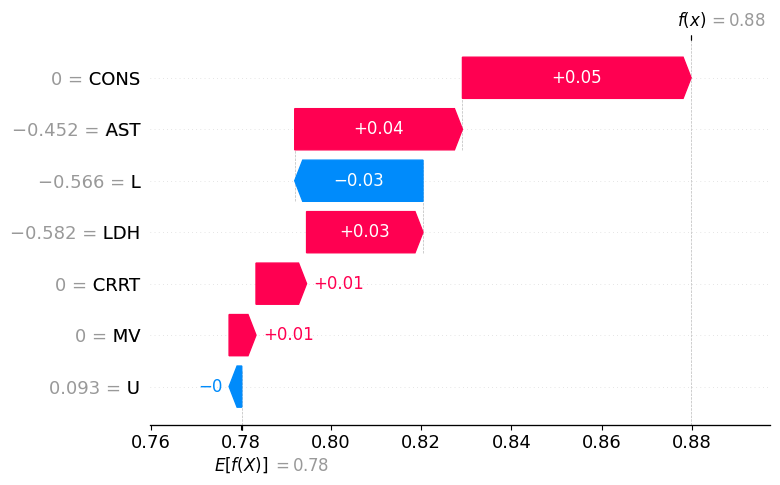

In [4]:
import matplotlib.pyplot as plt
import shap

# 假设已经有了 shap_values、model_xgb、X_train 和 selected_features

# 选择一个样本
sample_index = 1  # 选择特定样本的索引

# 创建针对单个样本和正类的Explanation对象
shap_values_single = shap.Explanation(
    values=shap_values.values[sample_index, :, 0],  # 提取正类的SHAP值
    base_values=shap_values.base_values[sample_index, 0],  # 提取正类的基础值
    data=shap_values.data[sample_index, :],  # 提取样本的特征数据
    feature_names=selected_features  # 特征名称
)

# 绘制瀑布图
shap.plots.waterfall(shap_values_single, max_display=10)  # 控制显示的特征数量

plt.show()


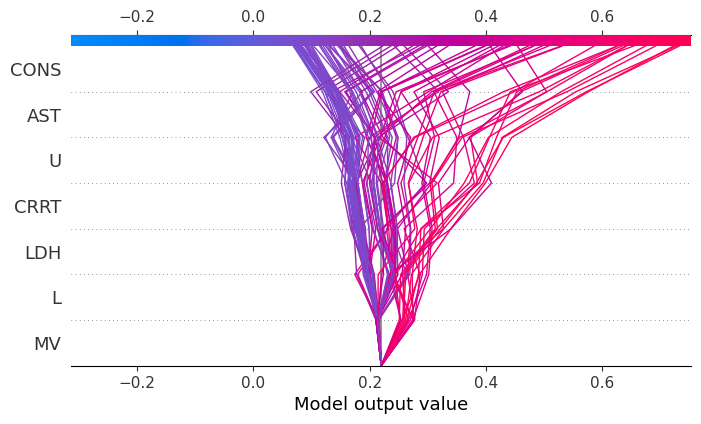

In [18]:
import shap

# 假设 shap_values_positive_class 已经是你想分析的SHAP值，例如正类的SHAP值
# X_internal_test[selected_features] 是对应的特征数据

# 计算所有样本的平均SHAP值（可选）
expected_value = shap_values_positive_class.base_values.mean()

# 绘制决策图
shap.decision_plot(expected_value, shap_values_positive_class.values, X_internal_test[selected_features])

plt.show()


In [2]:
import joblib
joblib.dump(model_xgb , 'XGBoost.pkl')

['XGBoost.pkl']

In [1]:
import streamlit as st
import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

In [3]:
model = joblib.load('XGBoost.pkl')


In [2]:
cons_options = {
    0: '意识没有改变 (0)',  # No change in consciousness
    1: '意识改变 (1)'       # Change in consciousness
}
mv_options = {
    0: '未应用 (0)',  # Not applied
    1: '应用 (1)'     # Applied
}
crrt_options = {
    0: '未应用 (0)',  # Not applied
    1: '应用 (1)'     # Applied
}


In [10]:
feature_names = ['CONS', 'LDH', 'MV', 'AST', 'CRRT', 'U', 'L']


In [11]:
st.title(" Predictor")


2024-09-01 15:33:23.909 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 15:33:24.364 
  command:

    streamlit run d:\py\Anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-09-01 15:33:24.365 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()